In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import cv2
import warnings
import mediapipe as mp
import joblib
from random import sample
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [7]:
import mlflow
import mlflow.xgboost

In [8]:
df = pd.read_csv("C:\\Users\\mo\\Desktop\\ml_research\\notebooks\\datasets\\hand_landmarks_data.csv")

In [9]:
df.head(5)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [10]:
def plot_hand_landmarks(df, n_samples=30, n_rows=5, n_cols=6, figsize=(30, 25)):
  sampled_df = df.sample(n=min(n_samples, len(df)))
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  fig.suptitle("Random Hand Gesture Samples", fontsize=16, y=1.02)
  axes = axes.flatten()

  connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),
        (0, 5), (5, 6), (6, 7), (7, 8),
        (0, 9), (9, 10), (10, 11), (11, 12),
        (0, 13), (13, 14), (14, 15), (15, 16),
        (0, 17), (17, 18), (18, 19), (19, 20),
        (5, 9), (9, 13), (13, 17)]

  for ax, (_, row) in zip(axes, sampled_df.iterrows()):
        x = [row[f'x{i}'] for i in range(1, 22)]
        y = [row[f'y{i}'] for i in range(1, 22)]
        ax.scatter(x, y, s=30, c='blue', alpha=0.6)

        for start, end in connections:
            ax.plot([x[start], x[end]], [y[start], y[end]], 'r-', linewidth=0.8)
        ax.set_title(row.get('label', 'Unknown'), fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()
  for ax in axes[len(sampled_df):]:
        ax.axis('off')
  plt.tight_layout()
  plt.show()

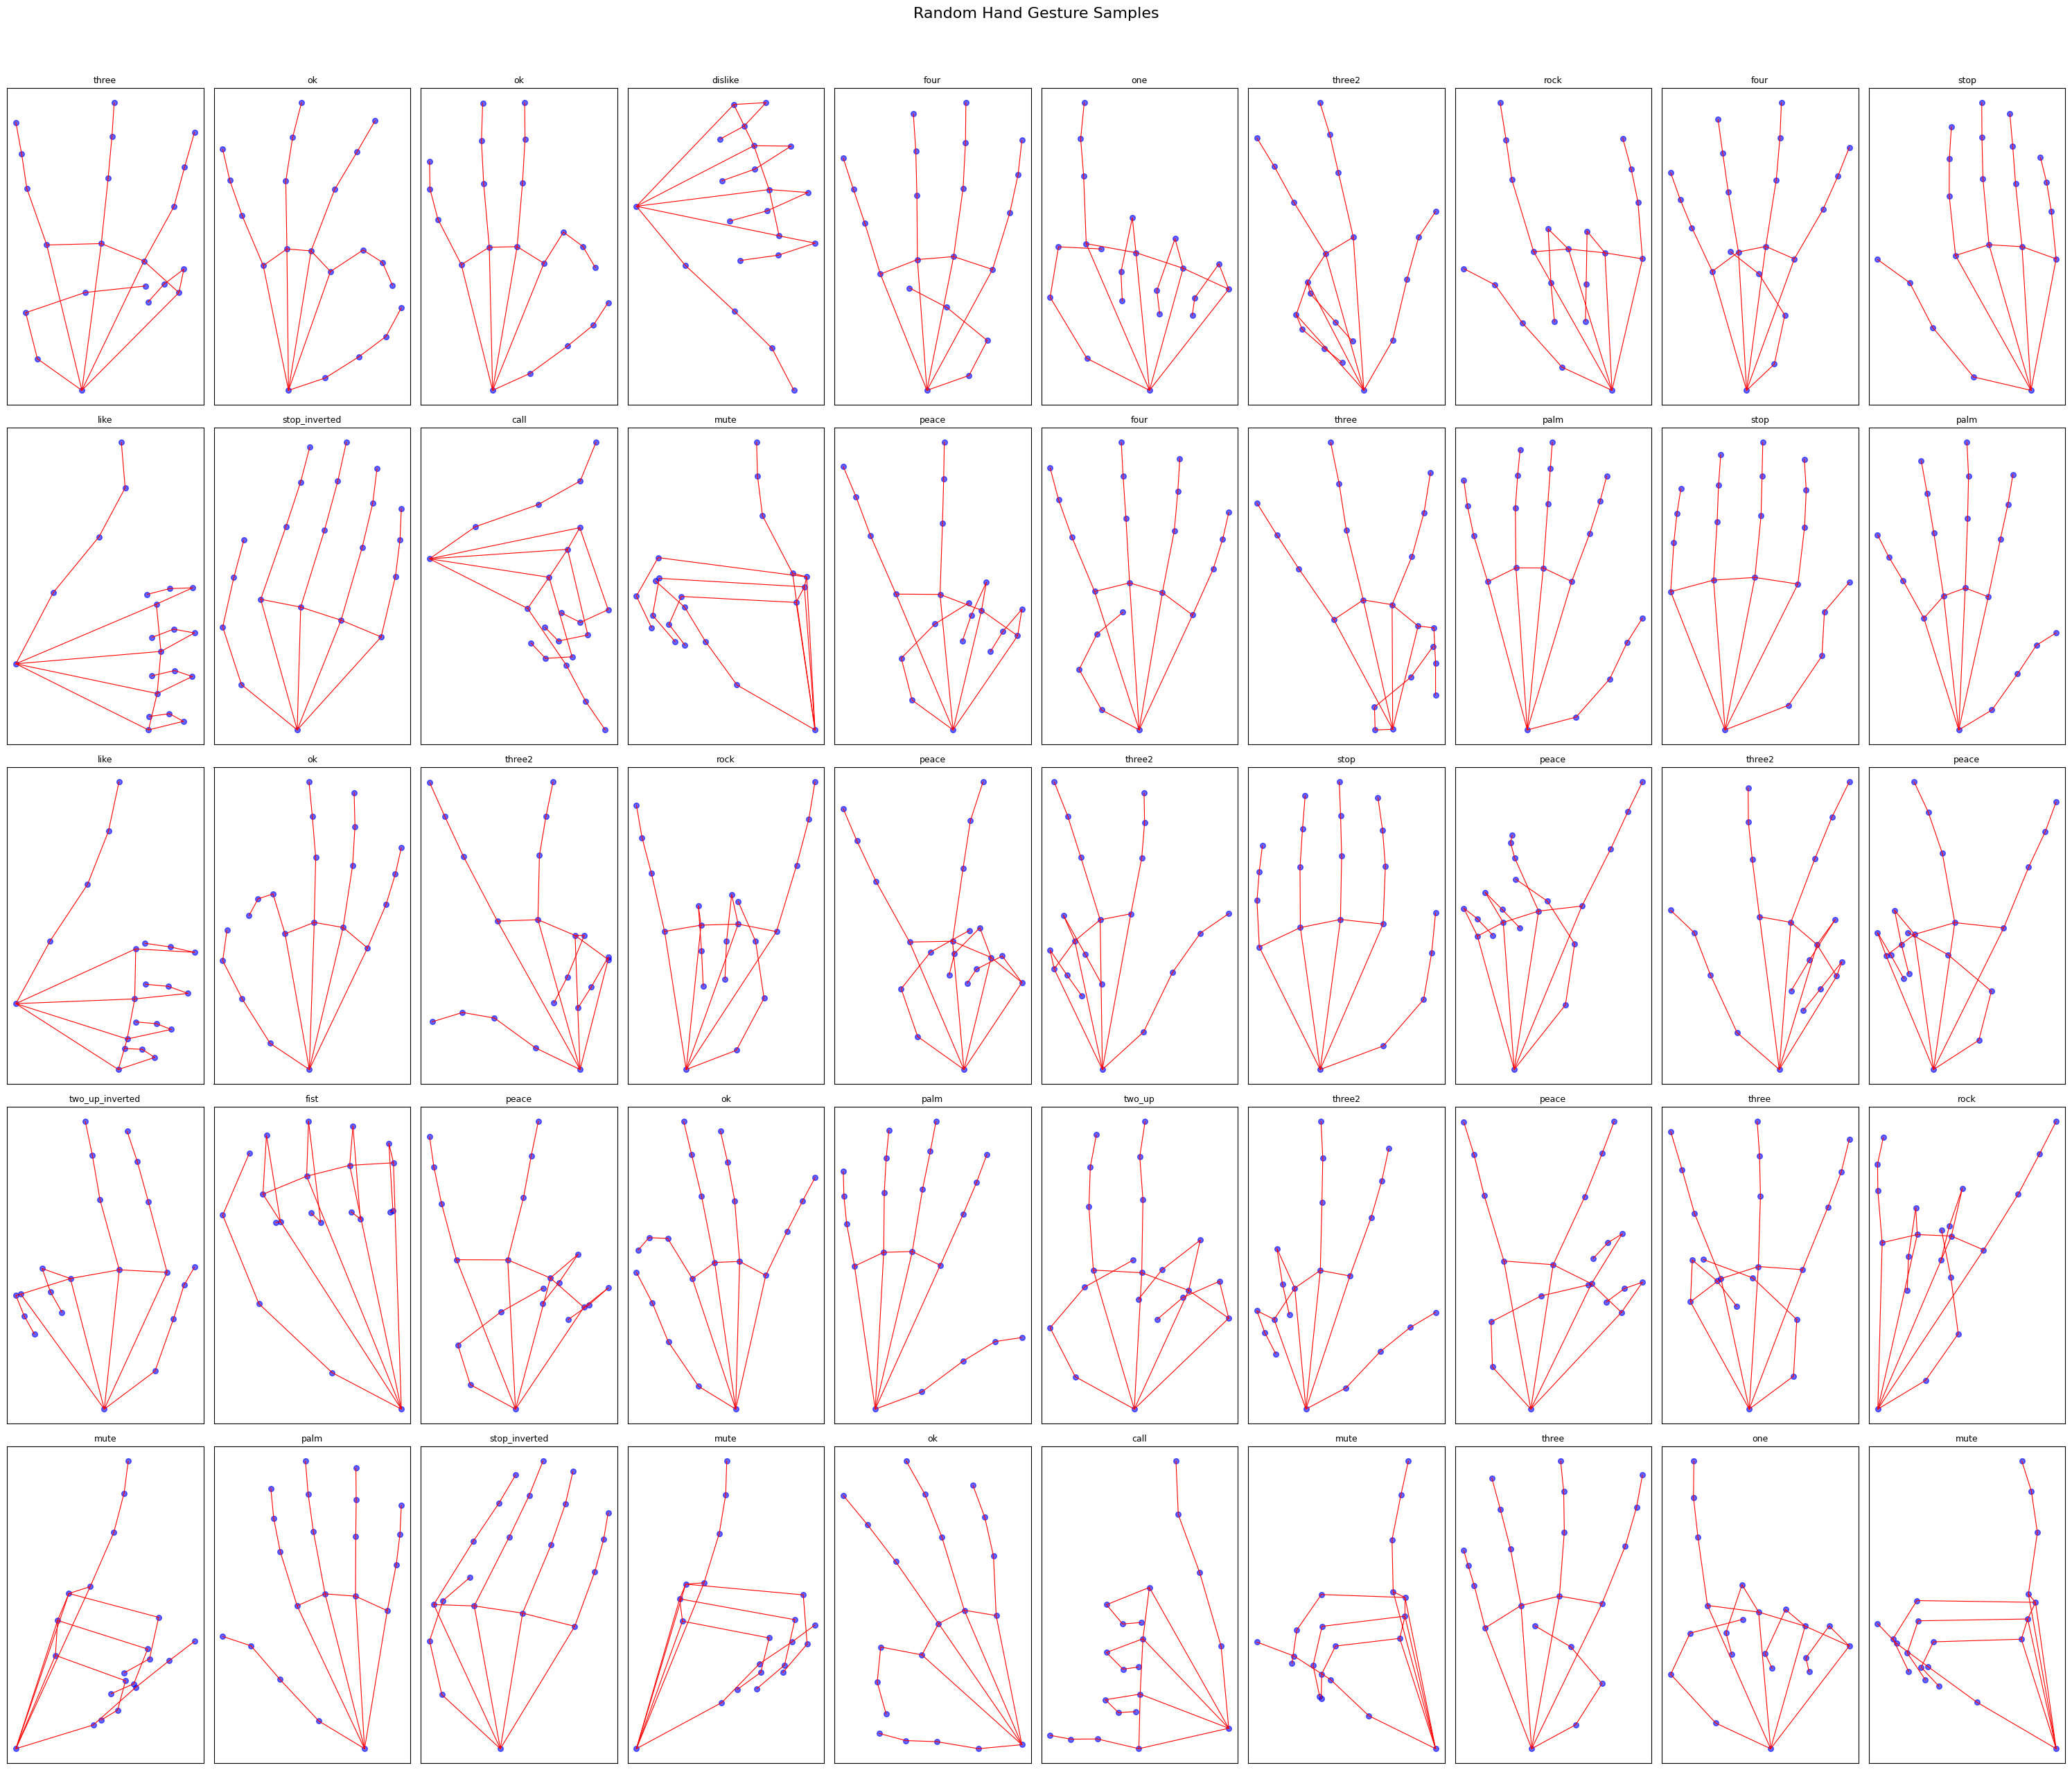

In [11]:
plot_hand_landmarks(df, n_samples=50, n_rows=5, n_cols=10)

In [12]:
distribution = df['label'].value_counts()
print(distribution)

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


In [13]:
nullvals = df.isnull().sum()
print(nullvals)

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64


In [14]:
duplicated_values = df.duplicated().sum()
print(duplicated_values)

0


In [15]:
def recentered_hands(df):
    leftpalm = df['x1'].values
    rightpalm = df['y1'].to_values
    mid_Lfin = df['x13'].to_values
    mid_Rfin = df['y13'].to_values

    scale = np.sqrt((mid_Lfin - leftpalm)**2 + (mid_Rfin - rightpalm)**2)
#returning all to normal positions!
    for hands in range(1, 22):
        df[f'x{hands}'] = (df[f'x{hands}'] - leftpalm) / scale
        df[f'y{hands}'] = (df[f'y{hands}'] - rightpalm) / scale

    return df

In [16]:
# data preprocessing
def data_preprocesssing(df):
    X = df.drop('label', axis=1)
    y = df['label']

    label_enc = LabelEncoder()
    y_encoded = label_enc.fit_transform(y)

    with open('label_enc.pkl', 'wb') as f:
        pickle.dump(label_enc, f)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_enc

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test, label_enc = data_preprocesssing(df)

In [18]:
import mlflow
import mlflow.xgboost
import mlflow.sklearn

def training_models(X_train, y_train, X_val, y_val):
    print("Training models:")

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
        'KNN': KNeighborsClassifier(),
        'XGBoost': XGBClassifier(random_state=42)
    }

    results = []
    
    # Set experiment name
    mlflow.set_experiment("HandGesture-Experiment")

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model.fit(X_train, y_train)
            train_acc = model.score(X_train, y_train)
            val_acc = model.score(X_val, y_val)
            report = classification_report(y_val, model.predict(X_val), output_dict=True)

            # Log parameters (add hyperparameters if available)
            mlflow.log_param("model_type", name)
            if name == 'XGBoost':
                mlflow.log_param("n_estimators", model.get_params().get('n_estimators', 'default'))
                mlflow.log_param("max_depth", model.get_params().get('max_depth', 'default'))
                mlflow.xgboost.log_model(model, "xgboost_model")
            else:
                mlflow.sklearn.log_model(model, "sklearn_model")

            # Log metrics
            mlflow.log_metric("Train Accuracy", train_acc)
            mlflow.log_metric("Validation Accuracy", val_acc)
            mlflow.log_metric("Recall", report['weighted avg']['recall'])
            mlflow.log_metric("Precision", report['weighted avg']['precision'])
            mlflow.log_metric("F1", report['weighted avg']['f1-score'])

            results.append({
                'Model': name,
                'Train Acc': train_acc,
                'Val Acc': val_acc,
                'Recall': report['weighted avg']['recall'],
                'Precision': report['weighted avg']['precision'],
                'F1': report['weighted avg']['f1-score']
            })

    train_df = pd.DataFrame(results)
    print(train_df.sort_values('Val Acc'))
    return train_df


In [19]:
  train_df = training_models(X_train, y_train, X_val, y_val)

2025/06/02 21:43:18 INFO mlflow.tracking.fluent: Experiment with name 'HandGesture-Experiment' does not exist. Creating a new experiment.


Training models:


2025/06/02 21:43:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/02 21:48:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/02 21:48:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/02 21:48:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\mo\Desktop\.conda\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [21:49:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  Y

                 Model  Train Acc   Val Acc    Recall  Precision        F1
3                  KNN   0.835443  0.714524  0.714524   0.727261  0.717072
1                  SVM   0.726582  0.719811  0.719811   0.756284  0.718308
2  Logistic Regression   0.823418  0.811909  0.811909   0.812054  0.810988
0        Random Forest   1.000000  0.834446  0.834446   0.835463  0.834461
4              XGBoost   1.000000  0.921536  0.921536   0.923223  0.921876


In [20]:
def tuning_logistic_regression(X_train, y_train):
    print("Fine tuning Logistic Regression\n")

    logreg = LogisticRegression(max_iter=500, random_state=42)
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = GridSearchCV(estimator=logreg,param_grid=param_grid,cv=cv,scoring='accuracy',n_jobs=1,verbose=2)

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print("Best Parameters:", best_params)
    print("Best CV Accuracy:", best_score)

    return best_model, best_params, best_score

In [21]:
best_model_lr, best_params_lr, best_score_lr = tuning_logistic_regression(X_train, y_train)

Fine tuning Logistic Regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  40.6s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  37.5s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  34.9s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time= 1.1min
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time= 1.1min
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time= 1.1min
[CV] END .................C=10, penalty=l2, solver=liblinear; total time= 1.4min
[CV] END .................C=10, penalty=l2, solver=liblinear; total time= 1.4min
[CV] END .................C=10, penalty=l2, solver=liblinear; total time= 1.5min
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy: 0.9029209631157015


In [22]:
def tune_svm(X_train, y_train):
    print("Fast SVM tuning\n")

    X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

    model = SVC(C=1, gamma=0.1, kernel='rbf', random_state=42)

    model.fit(X_sample, y_sample)

    print("SVM model fitted on sample data.")
    return model

In [23]:
best_svm = tune_svm(X_train, y_train)

Fast SVM tuning

SVM model fitted on sample data.


In [24]:
def models_evaluation(models, X_train, y_train, X_val, y_val):
    results = []

    for name, model in models.items():
        print(f"Evaluating {name}...")
        model.fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_val, y_val)
        report = classification_report(y_val, model.predict(X_val), output_dict=True)

        results.append({
            'Model': name,
            'Train Acc': train_acc,
            'Val Acc': val_acc,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1': report['weighted avg']['f1-score']
        })

        print(f"{name} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    results_df = pd.DataFrame(results)
    print("Model Comparison:")
    print(results_df)

    best_model_name = results_df.loc[results_df['Val Acc'].idxmax(), 'Model']
    best_model = models[best_model_name]
    print(f"Best Model: {best_model_name} (Val Acc: {results_df['Val Acc'].max():.4f})")

    return results_df, best_model_name, best_model

In [25]:
best_models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': best_svm,
    'Logistic Regression': best_model_lr
}

In [26]:
results_df, best_model_name, best_model = models_evaluation(best_models, X_train, y_train, X_val, y_val)

Evaluating KNN...
KNN - Train Acc: 0.8354, Val Acc: 0.7145
Evaluating Random Forest...
Random Forest - Train Acc: 1.0000, Val Acc: 0.8344
Evaluating XGBoost...
XGBoost - Train Acc: 1.0000, Val Acc: 0.9215
Evaluating SVM...
SVM - Train Acc: 1.0000, Val Acc: 0.0607
Evaluating Logistic Regression...
Logistic Regression - Train Acc: 0.9092, Val Acc: 0.8990
Model Comparison:
                 Model  Train Acc   Val Acc  Precision    Recall        F1
0                  KNN   0.835443  0.714524   0.727261  0.714524  0.717072
1        Random Forest   1.000000  0.834446   0.835463  0.834446  0.834461
2              XGBoost   1.000000  0.921536   0.923223  0.921536  0.921876
3                  SVM   1.000000  0.060657   0.003679  0.060657  0.006938
4  Logistic Regression   0.909153  0.898998   0.901437  0.898998  0.899242
Best Model: XGBoost (Val Acc: 0.9215)


In [27]:
def best_test(models, X_test, y_test):
    results = []

    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Test Accuracy': f"{test_acc:.4f}"
        })

        print(f"{model_name}: {test_acc:.4f}")

    print("\nTest Accuracy Summary:")
    print("-" * 50)
    test_results_df = pd.DataFrame(results)
    print(test_results_df.to_markdown(index=False, tablefmt="grid"))

    if results and all('Error' not in resul['Test Accuracy'] for resul in results):
        best_test_model = max(results, key=lambda x: float(x['Test Accuracy']))
        print(f"\nBest model on test set: {best_test_model['Model']} with accuracy {best_test_model['Test Accuracy']}")
    else:
        best_test_model = None

    return test_results_df, best_test_model

In [28]:
test_results_df, best_test_model_info = best_test(best_models, X_test, y_test)

KNN: 0.7320
Random Forest: 0.8462
XGBoost: 0.9358
SVM: 0.0642
Logistic Regression: 0.9091

Test Accuracy Summary:
--------------------------------------------------


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [ ]:
with open('best_model_XGBoost.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved as 'best_model_XGBoost.pkl'.")


Best model saved as 'best_model_XGBoost.pkl'.


In [ ]:
mlflow.set_experiment("HandGesture-Experiment")
with mlflow.start_run():
    model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    
    mlflow.log_param("model_type", "XGBoostClassifier")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_metric("accuracy", acc)
    mlflow.xgboost.log_model(model, "xgboost_model")


In [ ]:
def load_fn():

    svm_model = pickle.load(open("best_model_XGBoost.pkl", "rb"))
    label_encoder = pickle.load(open("label_enc.pkl", "rb"))

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

    cap = cv2.VideoCapture(0)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter("output.mp4", fourcc, 30, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_frame)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                wrist_x, wrist_y, wrist_z = landmarks[0]
                landmarks[:, 0] -= wrist_x
                landmarks[:, 1] -= wrist_y

                mid_finger_x, mid_finger_y, _ = landmarks[12]
                scale_factor = np.sqrt(mid_finger_x**2 + mid_finger_y**2)
                landmarks[:, 0] /= scale_factor
                landmarks[:, 1] /= scale_factor

                features = landmarks.flatten().reshape(1, -1)
                numeric_prediction = svm_model.predict(features)[0]
                label_prediction = label_encoder.inverse_transform([numeric_prediction])[0]

                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.putText(frame, f'Prediction: {label_prediction}', (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        out.write(frame)
        cv2.imshow("Hand Gesture Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
load_fn()